In [193]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve, make_scorer, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import warnings

In [194]:
# Ignoring warnings because there are some warnings related to SettingWithCopyWarning 
# inspite of using the correct code (.loc[row_indexer,col_indexer] = value)

warnings.simplefilter('ignore') 

## Read Data from .csv file where the pre-processed data is stored

In [195]:
df_marvel = pd.read_csv('../data/marvel.csv')

In [196]:
df_DC = pd.read_csv('../data/DC.csv')

In [197]:
df_marv_dc_1 = pd.read_csv('../data/df_marv_dc_1.csv')

In [198]:
df_marv_dc_1.shape

(4209, 11)

In [199]:
df_marv_dc_1.columns

Index(['title_desc', 'subreddit', 'tokens', 'tokens_len', 'tokens_nostop',
       'tokens_lemmatized', 'tokens_lem_len', 'tokens_stemmed',
       'tokens_stem_len', 'title_desc_new', 'title_desc_new_stem'],
      dtype='object')

In [200]:
df_marv_dc_1.head()

,title_desc,subreddit,tokens,tokens_len,tokens_nostop,tokens_lemmatized,tokens_lem_len,tokens_stemmed,tokens_stem_len,title_desc_new,title_desc_new_stem
0,"Hey i just realized something, Ant-man Black P...",marvelstudios,"['hey', 'just', 'realized', 'something', 'ant'...",32,"['hey', 'realized', 'something', 'ant', 'black...","['hey', 'realized', 'something', 'ant', 'black...",22,"['hey', 'realiz', 'someth', 'ant', 'black', 'p...",22,hey realized something ant black panther wasp ...,hey realiz someth ant black panther wasp aveng...
1,Talking Loki,marvelstudios,"['talking', 'loki']",2,"['talking', 'loki']","['talking', 'loki']",2,"['talk', 'loki']",2,talking loki,talk loki
2,"""What? I'm invested."" | Darcy Lewis Portrait D...",marvelstudios,"['what', 'invested', 'darcy', 'lewis', 'portra...",9,"['invested', 'darcy', 'lewis', 'portrait', 'ka...","['invested', 'darcy', 'lewis', 'portrait', 'ka...",7,"['invest', 'darci', 'lewi', 'portrait', 'kat',...",7,invested darcy lewis portrait kat dennings wan...,invest darci lewi portrait kat den wandavis
3,"Natasha : Daughter of Alexei. In Infinity War,...",marvelstudios,"['natasha', 'daughter', 'of', 'alexei', 'in', ...",107,"['natasha', 'daughter', 'alexei', 'infinity', ...","['natasha', 'daughter', 'alexei', 'infinity', ...",109,"['natasha', 'daughter', 'alexei', 'infin', 'wa...",109,natasha daughter alexei infinity war thanos ga...,natasha daughter alexei infin war thano gamora...
4,(Insert Loki Theory here)…Well yeah...,marvelstudios,"['insert', 'loki', 'theory', 'here', 'well', '...",6,"['insert', 'loki', 'theory', 'well', 'yeah']","['insert', 'loki', 'theory', 'well', 'yeah']",5,"['insert', 'loki', 'theori', 'well', 'yeah']",5,insert loki theory well yeah,insert loki theori well yeah


# 3. Modelling

 Rubric TBD  
 
 Preprocessing and Modeling

 <s>Is text data successfully converted to a matrix representation?</s><br>
 <s>Are methods such as stop words, stemming, and lemmatization explored?</s>
 <s>Does the student properly split and/or sample the data for validation/training purposes?</s><br>
 <s>Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: Random Forest and one other model)?</s><br>
 <s>Does the student defend their choice of production model relevant to the data at hand and the problem?</s><br>
 <s>Does the student explain how the model works and evaluate its performance successes/downfalls?</s><br>

 Evaluation and Conceptual Understanding

 <s>Does the student accurately identify and explain the baseline score?</s><br>
 <s>Does the student select and use metrics relevant to the problem objective?</s><br>
 Does the student interpret the results of their model for purposes of inference?<br>
 Is domain knowledge demonstrated when interpreting results?<br>
 Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?<br>

###  Baseline Accuracy

In [201]:
df_marv_dc_1['subreddit'].value_counts(normalize=True)

DC_Cinematic     0.508434
marvelstudios    0.491566
Name: subreddit, dtype: float64

As the proportion of posts between marvel and DC is around 50.8% to 49.2% the baseline accuracy of our model will be 0.508. This is because even if we predict all posts to be from marvel, even then we will be 50.8% accurate. So our model should at the very least do better than this score. 

### Let's define X, y and do a train test split

In [202]:
df_marv_dc_1.isna().sum()

title_desc              0
subreddit               0
tokens                  0
tokens_len              0
tokens_nostop           0
tokens_lemmatized       0
tokens_lem_len          0
tokens_stemmed          0
tokens_stem_len         0
title_desc_new         25
title_desc_new_stem    25
dtype: int64

In [203]:
# We replace the NA values in title_desc_new and title_desc_new_stem 
# with blank strings (due to pre-processing)
df_marv_dc_1 = df_marv_dc_1.fillna('')


In [204]:
# Set X and y variables. We map DC_Cinematic subreddit as 1 and marvelstudios as 0
X = df_marv_dc_1['title_desc_new']
y = df_marv_dc_1['subreddit'].map({'marvelstudios':0, 'DC_Cinematic':1})


In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

### Some functions to help modelling

In [206]:
def plot_roc_auc_curve(model, X_test_values, y_test_values):
    
    y_pred_proba = model.predict_proba(X_test_values)[:,1]
    fpr, tpr, _ = roc_curve(y_test_values,  y_pred_proba)
    auc = roc_auc_score(y_test_values, y_pred_proba)
    
    plt.plot(fpr,tpr,label="data, auc=" + str(round(auc,4)))
    plt.title("ROC Curve")
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
    plt.legend(loc=4)
    plt.show()
    
    return auc


In [207]:
def analyse_model_performance(model, X_train_values, y_train_values, X_test_values, y_test_values):
    
    
    # Get predictions
    preds = model.predict(X_test_values)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_values, preds).ravel()

    dict_scores = {'model': str(model.estimator.steps),
                'cross_val_score': model.best_score_, 
                'train_auc_score': model.score(X_train_values, y_train_values),
                'test_auc_score': model.score(X_test_values, y_test_values),
                'train_accuracy_score': accuracy_score(y_train_values, model.predict(X_train_values)),
                'test_accuracy_score': accuracy_score(y_test_values, model.predict(X_test_values)),               
                'sensitivity': tp / (tp + fn),
                'specificity': tn / (tn + fp)
              }

    print(f"****Best Params****: \n{model.best_params_}\n")
    print(f"****Cross Val Score****: \n{dict_scores['cross_val_score']}\n")
    print(f"****Train AUC Score****: \n{dict_scores['train_auc_score']}\n")
    print(f"****Test AUC Score ****: \n{dict_scores['test_auc_score']}\n")
    print(f"****Train Accuracy Score****: \n{dict_scores['train_accuracy_score']}\n")
    print(f"****Test Accuracy Score ****: \n{dict_scores['test_accuracy_score']}\n")
    print(f"****Sensitivity****: \n{dict_scores['sensitivity']}\n")    
    print(f"****Specificity****: \n{dict_scores['specificity']}\n")

    plt.figure(figsize=(9,9));
    cf = plot_confusion_matrix(model, X_test_values, y_test_values, display_labels=['marvelstudios', 'DC_Cinematic'], cmap='Blues', values_format='d');
    plt.show();
    
    plt.figure(figsize=(6,6));
    auc = plot_roc_auc_curve(model, X_test, y_test);
    plt.show();
    
    return dict_scores


In [208]:
# Get most important words based on coefficients of the logistic regression model
def get_important_features_lr(vectoriser, estimator, n):
    feature_names = pd.DataFrame(vectoriser.get_feature_names(), columns=['feature_name'])    
    
    df_coef = pd.DataFrame(estimator.coef_)
    df_coef = df_coef.T
    
    df_coef = pd.concat([df_coef, feature_names], axis=1)    
    df_coef = df_coef.rename(columns={0:'value'})    
        
    return df_coef.sort_values(by='value', ascending=True)[:20], df_coef.sort_values(by='value', ascending=False)[:20]

In [209]:
# plot most important words passed in the two datasets
def plot_important_words(df_coef1, df_coef2, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title, y=0.93)

    plot1 = df_coef1.sort_values(by='value', ascending=False)[:20].plot(kind='barh', y='value', x='feature_name', 
                                                                     ax=axes[0], figsize=(12,10), label='_', 
                                                                       fontsize=12, color='salmon');
    plot1.set_xlabel('Importance', fontsize=12)
    plot1.set_ylabel('Words', fontsize=12)
    plot1.set_title('Marvel Studios')
    
    plot2 = df_coef2.sort_values(by='value', ascending=True)[:20].plot(kind='barh', y='value', 
                                                                  x='feature_name', fontsize=12,
                                                             ax=axes[1], figsize=(12,10),label='_', 
                                                                        color='skyblue');

    plot2.set_xlabel('Importance', fontsize=12)
    plot2.set_ylabel('Words', fontsize=12)
    plot2.set_title('DC Cinematic')

    plt.subplots_adjust(wspace=0.8)
    plt.show()

## a. CountVectorizer + Logistic Regression

In [210]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [211]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [4_000],
    'cvec__min_df': [2],
    'cvec__max_df': [.85, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__C': np.logspace(-2, 2, 50),
    'lr__solver': ['liblinear'],
    'lr__random_state': [123],
    'lr__penalty': ['l1','l2'],
    'lr__random_state': [123]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [212]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.


In [213]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [4000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372...
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'lr__penalty': ['l1', 'l2'], 'lr__random_state': [123],
                         'lr__solver': ['liblinear']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                  

****Best Params****: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 0.04498432668969444, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear'}

****Cross Val Score****: 
0.979380839045476

****Train AUC Score****: 
0.9942849674335578

****Test AUC Score ****: 
0.9817736943227936

****Train Accuracy Score****: 
0.9080108621860149

****Test Accuracy Score ****: 
0.8709422011084719

****Sensitivity****: 
0.9937694704049844

****Specificity****: 
0.7439613526570048



<Figure size 648x648 with 0 Axes>

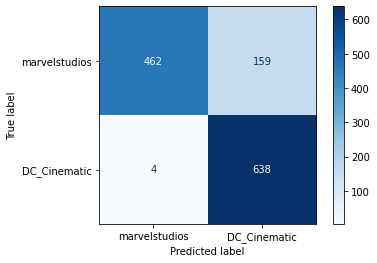

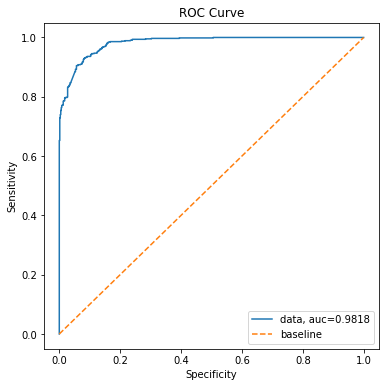

In [265]:
score_dict = {}
score_dict = analyse_model_performance(gs, X_train, y_train, X_test, y_test)
score_dict['model'] ="CountVec + Logistic Regression"
scores = []
scores.append(score_dict)


We see that the training score and test score are quite high, and much higher than the baseline. However the test score is more than 5% lower than the train score, showing evidence of overfitting. 

The model considers DC as a positive result and marvel as a negative result. Sensitivity rate shows true positive rate i.e. the rate of getting correct DC predictions. And the specificity shows the rate of getting correct Marvel predictions. 

The sensitivity and specificity scores also indicate that our model predicts true positives (in our case DC_Cinematic subreddits) at a slightly higher rate than true negatives (in our case mervelstudios subreddits) as the sensitivity is higher than specificity.

AUC of the model is quite close to 1 which shows a high measure of separability i.e. capability of the model to distinguish between the two classes is quite high. 

### Which Metrics to focus on?
The classification problem that we are trying to solve has two classes which we would like the model to predict equally well. i.e. we do not have a preference for getting either True Positives or True Negatives more accurately. Hence in this case Accuracy is the chosen metric that we will use to evaluate our model. In addition AUC will be used to gauge the separability of the two classes in each model. 

### Finding the top predictors

In [215]:
df_coef_marvel, df_coef_DC = get_important_features_lr(gs.best_estimator_.named_steps.cvec, gs.best_estimator_.named_steps.lr, 20)


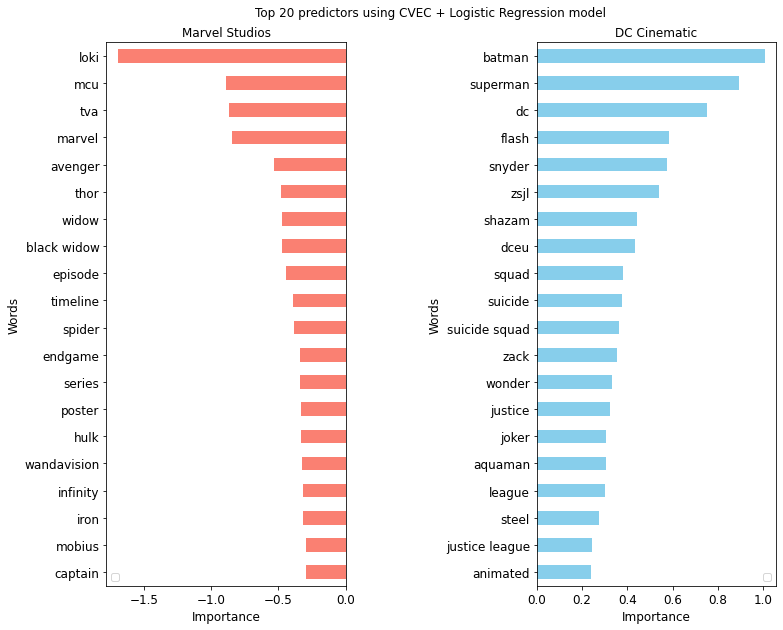

In [216]:
plot_important_words(df_coef_marvel, df_coef_DC, title="Top 20 predictors using CVEC + Logistic Regression model")


The top 20 predictors of the model show that model is giving importance to the right words relevant to Marvel and DC characters. We can see that the model gives more importance to 1-gram words rather than 2-gram words, as we had specified both 1 gram and 2 gram ranges in the GridSearchCV. 

## b. TFIDFVectorizer + Logistic Regression

In [217]:
# Set up a pipeline with tf-idf vectorizer and LogisticRegression

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [218]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000
# English stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [3_000, 4_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (2,2)],
    'lr__C': np.logspace(-2, 2, 50),
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__penalty': ['l1','l2'],
    'lr__random_state': [123]
}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [219]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.

In [220]:

# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-...
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'lr__penalty': ['l1', 'l2'], 'lr__random_state': [123],
                         'lr__solver': ['liblinear', 'lbfgs'],
                         'tvec__max_features': [3000, 4000],
                         'tvec__ngram_range': [(1, 1), (2, 2)],
                         'tvec__stop_words': ['english']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': 

****Best Params****: 
{'lr__C': 0.6250551925273969, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear', 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

****Cross Val Score****: 
0.9824036620630329

****Train AUC Score****: 
0.9972721455494988

****Test AUC Score ****: 
0.9839521222427899

****Train Accuracy Score****: 
0.9670739986422268

****Test Accuracy Score ****: 
0.9184481393507522

****Sensitivity****: 
0.9735202492211839

****Specificity****: 
0.8615136876006442



<Figure size 648x648 with 0 Axes>

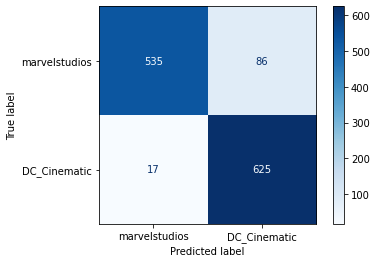

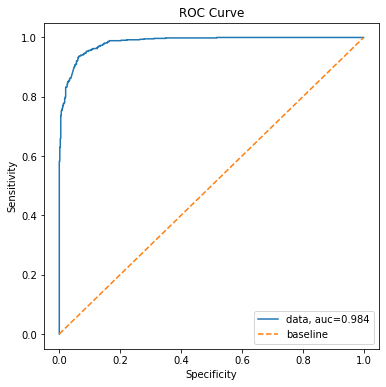

[{'model': 'CountVec + Logistic Regression',
  'cross_val_score': 0.979380839045476,
  'train_auc_score': 0.9942849674335578,
  'test_auc_score': 0.9817736943227936,
  'train_accuracy_score': 0.9080108621860149,
  'test_accuracy_score': 0.8709422011084719,
  'sensitivity': 0.9937694704049844,
  'specificity': 0.7439613526570048},
 {'model': 'TF-IDFVec + Logistic Regression',
  'cross_val_score': 0.9824036620630329,
  'train_auc_score': 0.9972721455494988,
  'test_auc_score': 0.9839521222427899,
  'train_accuracy_score': 0.9670739986422268,
  'test_accuracy_score': 0.9184481393507522,
  'sensitivity': 0.9735202492211839,
  'specificity': 0.8615136876006442}]

In [266]:
score_dict = analyse_model_performance(gs_tvec, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="TF-IDFVec + Logistic Regression"
scores

Using TFIDF we see that our model gives us a slightly better test score thus reducing overfitting. Both test and train scores are better than the baseline scores and are thus acceptable.


We see that there is a difference between sensitivity (true positive rate) and specificity(true negative rate) showing that our model is slightly better at correctly predicting True positives i.e. DC posts than Marvel posts

AUC of this model is slightly better than the one with CountVectorizer, and quite close to 1 which shows a high measure of separability i.e. capability of the model to distinguish between the two classes is quite high. 

In [222]:
gs_tvec.best_estimator_.named_steps.lr.coef_

array([[-5.86219249e-05, -1.02588369e-04, -8.79328873e-05, ...,
         9.95773245e-02,  1.46614218e-02,  2.12563076e+00]])

### Finding the top predictors

In [223]:
df_coef_marvel, df_coef_DC = get_important_features_lr(gs_tvec.best_estimator_.named_steps.tvec, gs_tvec.best_estimator_.named_steps.lr, 20)
df_coef_marvel


,value,feature_name
1990,-6.461927,loki
3720,-3.603753,tva
2099,-3.423731,mcu
2081,-3.401678,marvel
3626,-2.307803,timeline
232,-2.198077,avenger
3900,-2.195480,widow
1036,-2.051975,episode
3599,-2.023906,thor
3352,-1.604980,spider


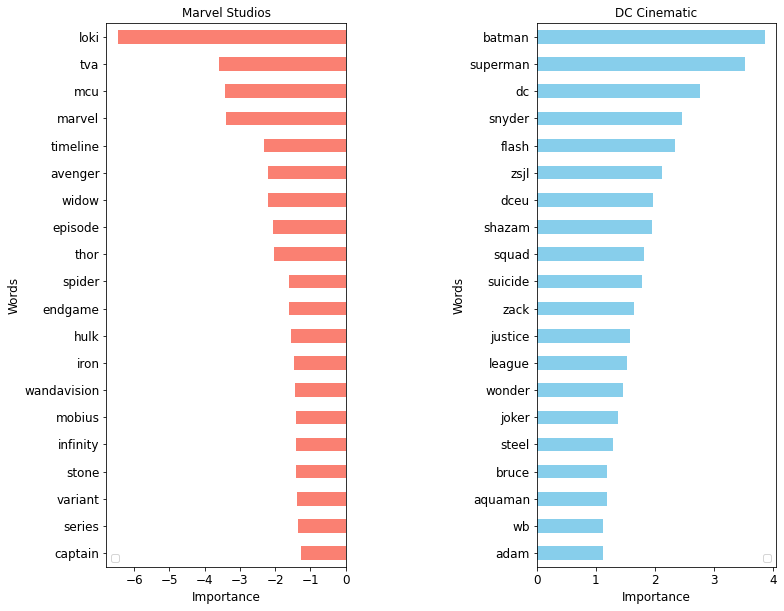

In [224]:
plot_important_words(df_coef_marvel, df_coef_DC, title="")
    

# c. CountVectorizer + Random Forests 

In [225]:
# Set up a pipeline with count vectorizer and Random Forests

pipe_vec2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [226]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 3000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# RandomForests: 
# No of trees in the random forest: 100, 150, 200
# Max depth: 1, 2, 3
pipe_vec2_params = {
    'cvec__max_features': [3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .85],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth': [None,4],
    'rf__random_state': [123]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [227]:

# Instantiate GridSearchCV.
gs_vec2 = GridSearchCV(pipe_vec2, # what object are we optimizing?
                        param_grid = pipe_vec2_params, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.

gs_vec2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.85],
                         'cvec__max_features': [3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [None, 4],
                         'rf__n_estimators': [150, 200, 250],
                         'rf__random_state': [123]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [228]:

# Fit GridSearch to training data.
gs_vec2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.85],
                         'cvec__max_features': [3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [None, 4],
                         'rf__n_estimators': [150, 200, 250],
                         'rf__random_state': [123]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

****Best Params****: 
{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__n_estimators': 150, 'rf__random_state': 123}

****Cross Val Score****: 
0.9730053163596537

****Train AUC Score****: 
0.9998928128849516

****Test AUC Score ****: 
0.9743341811268129

****Train Accuracy Score****: 
0.9955872369314325

****Test Accuracy Score ****: 
0.9113222486144101

****Sensitivity****: 
0.9485981308411215

****Specificity****: 
0.8727858293075684



<Figure size 648x648 with 0 Axes>

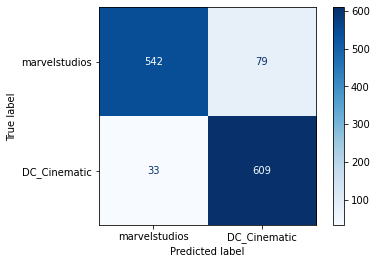

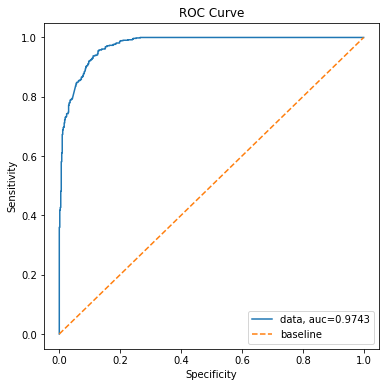

In [267]:
score_dict = analyse_model_performance(gs_vec2, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="CountVec + Random Forests"


Using Random Forests model with Count Vectoriser, we observe that both test and train scores are better than the baseline scores and are thus acceptable. However the test score / accuracy we observed is worse than with Logistic Regression. 

The AUC score shows high separability of classes however this is also observed to be lower than the Logistic Regression models. 

## d. TF-IDF Vectorizer + Random Forests 

In [230]:
# Set up a pipeline with tf-idf vectorizer and RandomForestClassifier

pipe_tvec2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [231]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000
# English stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec2_params = {
    'tvec__max_features': [4_000, 5_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None,4],
    'rf__random_state': [123]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [232]:
# Instantiate GridSearchCV.
gs_tvec2 = GridSearchCV(pipe_tvec2, # what object are we optimizing?
                        param_grid = pipe_tvec2_params, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.


In [233]:
# Fit GridSearch to training data.
gs_tvec2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 4],
                         'rf__n_estimators': [100, 150, 200],
                         'rf__random_state': [123],
                         'tvec__max_features': [4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

****Best Params****: 
{'rf__max_depth': None, 'rf__n_estimators': 200, 'rf__random_state': 123, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

****Cross Val Score****: 
0.9726823792389141

****Train AUC Score****: 
0.9998653822038962

****Test AUC Score ****: 
0.9754879829036676

****Train Accuracy Score****: 
0.9955872369314325

****Test Accuracy Score ****: 
0.9144893111638955

****Sensitivity****: 
0.9735202492211839

****Specificity****: 
0.8534621578099839



<Figure size 648x648 with 0 Axes>

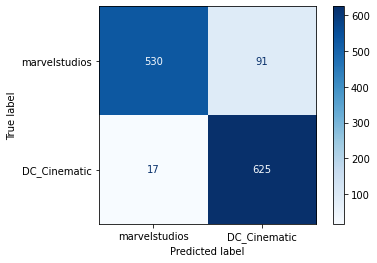

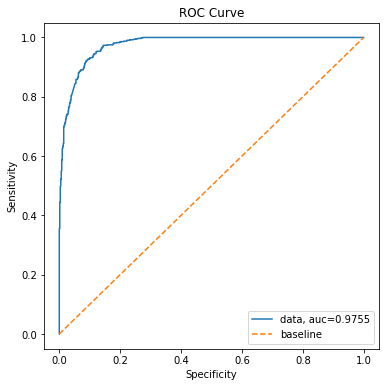

[{'model': 'CountVec + Logistic Regression',
  'cross_val_score': 0.979380839045476,
  'train_auc_score': 0.9942849674335578,
  'test_auc_score': 0.9817736943227936,
  'train_accuracy_score': 0.9080108621860149,
  'test_accuracy_score': 0.8709422011084719,
  'sensitivity': 0.9937694704049844,
  'specificity': 0.7439613526570048},
 {'model': 'TF-IDFVec + Logistic Regression',
  'cross_val_score': 0.9824036620630329,
  'train_auc_score': 0.9972721455494988,
  'test_auc_score': 0.9839521222427899,
  'train_accuracy_score': 0.9670739986422268,
  'test_accuracy_score': 0.9184481393507522,
  'sensitivity': 0.9735202492211839,
  'specificity': 0.8615136876006442},
 {'model': 'CountVec + Random Forests',
  'cross_val_score': 0.9730053163596537,
  'train_auc_score': 0.9998928128849516,
  'test_auc_score': 0.9743341811268129,
  'train_accuracy_score': 0.9955872369314325,
  'test_accuracy_score': 0.9113222486144101,
  'sensitivity': 0.9485981308411215,
  'specificity': 0.8727858293075684},
 {'mod

In [268]:
score_dict = analyse_model_performance(gs_tvec2, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="TF-IDF Vec + Random Forests"
scores

Using Random Forests model with TF-IDF Vectorizer, we observe that both test and train scores are better than the baseline scores and are thus acceptable. However the test score / accuracy we observed is slightly worse than TF-IDF with Logistic Regression. 

The AUC score shows high separability of classes however this is also observed to be lower than the Logistic Regression models. 

## e. CountVectorizer + Multinomial Naive Bayes

In [235]:
pipe_vec3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [239]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params_vec3 = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.8, 0.85, .9],
    'cvec__ngram_range': [(1,1), (1,2)]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [240]:
# Instantiate GridSearchCV.

gs_vec3 = GridSearchCV(pipe_vec3, 
                  param_grid=pipe_params_vec3, 
                  cv=5, scoring=scoring, refit='AUC') 

In [241]:
# Fit GridSearch to training data.
gs_vec3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.8, 0.85, 0.9],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

****Best Params****: 
{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}

****Cross Val Score****: 
0.9801111587671695

****Train AUC Score****: 
0.9885715484365896

****Test AUC Score ****: 
0.9818426716029316

****Train Accuracy Score****: 
0.9382213170400543

****Test Accuracy Score ****: 
0.9255740300870943

****Sensitivity****: 
0.9485981308411215

****Specificity****: 
0.9017713365539453



<Figure size 648x648 with 0 Axes>

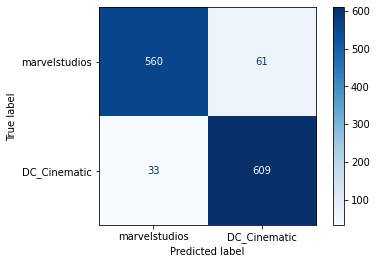

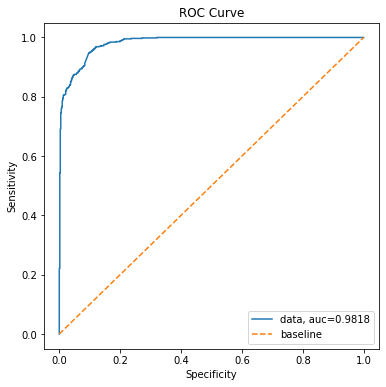

In [269]:
score_dict = analyse_model_performance(gs_vec3, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="CountVec + Multinomial Naive Bayes"

Using Multinomial Naive Bayes model with Count Vectorizer, we observe that both test and train scores are better than the baseline scores and are thus acceptable. The test score / accuracy we observed is more or less similar to Logistic Regression. 

The AUC score shows high separability of classes however this is also observed to be similar to the Logistic Regression models. 

## f. TFIDFVectorizer + Multinomial Naive Bayes

In [243]:
# Set up a pipeline with tf-idf vectorizer and LogisticRegression

pipe_tvec3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [245]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000
# English stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params3 = {
    'tvec__max_features': [3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (2,2)]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [246]:
# Instantiate GridSearchCV.
gs_tvec3 = GridSearchCV(pipe_tvec3, # what object are we optimizing?
                        param_grid = pipe_tvec_params3, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.

In [247]:
# Fit the pipeline model
gs_tvec3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (2, 2)],
                         'tvec__stop_words': [None, 'english']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

****Best Params****: 
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

****Cross Val Score****: 
0.9817378185674264

****Train AUC Score****: 
0.9969014855903635

****Test AUC Score ****: 
0.982188812135988

****Train Accuracy Score****: 
0.971826205023761

****Test Accuracy Score ****: 
0.9295328582739509

****Sensitivity****: 
0.9376947040498442

****Specificity****: 
0.9210950080515298



<Figure size 648x648 with 0 Axes>

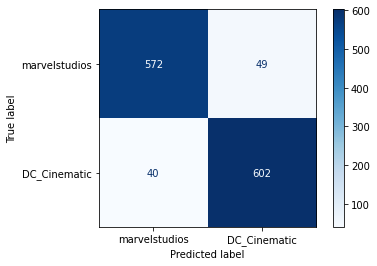

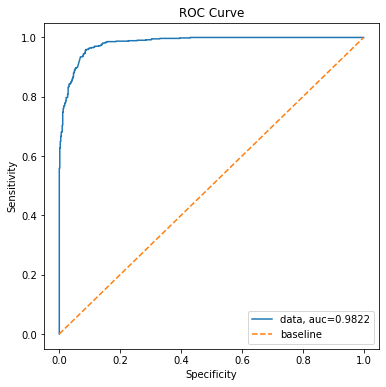

In [270]:
score_dict = analyse_model_performance(gs_tvec3, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] = "TF-IDFVec + Multinomial Naive Bayes"

Using Multinomial Naive Bayes model with TF-IDF Vectorizer, we observe that both test and train scores are better than the baseline scores and are thus acceptable. The test score / accuracy we observed is better than with Count Vectorizer and more or less similar to Logistic Regression. 

The AUC score shows high separability of classes however this is also observed to be similar to the Logistic Regression models. 

## Modelling with Stemmed Tokens

So far we have used lemmatised tokens for our models let's try a few models with Stemmed Tokens. We choose the Lgistic Regression with TFIDF and NaiveBayes with TF-IDF as these were the best models in our previous modeling

In [249]:
# Set X and y variables. We map DC_Cinematic subreddit as 1 and marvelstudios as 0
X1 = df_marv_dc_1['title_desc_new_stem']
y1 = df_marv_dc_1['subreddit'].map({'marvelstudios':0, 'DC_Cinematic':1})


In [250]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y, random_state=123)


## g. TFIDFVectorizer + Logistic Regression (With Stemming)

In [251]:
# Set up a pipeline with tf-idf vectorizer and LogisticRegression

pipe_tvec4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [252]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000
# English stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec4_params = {
    'tvec__max_features': [2_000, 3_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (2,2)],
    'lr__C': np.logspace(-2, 2, 50),
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__random_state':[123]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [253]:
# Instantiate GridSearchCV.
gs_tvec4 = GridSearchCV(pipe_tvec4, # what object are we optimizing?
                        param_grid = pipe_tvec4_params, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.

In [254]:

# Fit GridSearch to training data.
gs_tvec4.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-...
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'lr__random_state': [123],
                         'lr__solver': ['liblinear', 'lbfgs'],
                         'tvec__max_features': [2000, 3000],
                         'tvec__ngram_range': [(1, 1), (2, 2)],
                         'tvec__stop_words': ['english']},
             refit='AUC',
             scoring={'AUC': 'ro

****Best Params****: 
{'lr__C': 1.0985411419875584, 'lr__random_state': 123, 'lr__solver': 'liblinear', 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

****Cross Val Score****: 
0.9815663738266613

****Train AUC Score****: 
0.997989953455436

****Test AUC Score ****: 
0.981896599294676

****Train Accuracy Score****: 
0.9755600814663951

****Test Accuracy Score ****: 
0.9192399049881235

****Sensitivity****: 
0.9641744548286605

****Specificity****: 
0.8727858293075684



<Figure size 648x648 with 0 Axes>

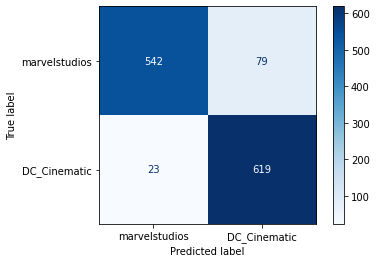

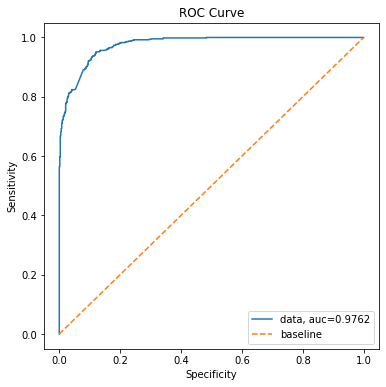

In [271]:
score_dict = analyse_model_performance(gs_tvec4, X1_train, y1_train, X1_test, y1_test)
scores.append(score_dict)
score_dict['model'] = "TF-IDF + Logistic Regression (Stemmed Tokens)"

The train and test scores are above baseline however we find that the logistic regression model with stemming actually does worse than the model with lemmatization. 

## h. TFIDFVectorizer + Multinomial Naive Bayes (With Stemming)

In [258]:
# Set up a pipeline with tf-idf vectorizer and LogisticRegression

pipe_tvec5 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [259]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000
# English stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params5 = {
    'tvec__max_features': [3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (2,2)]
}
scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [260]:
# Instantiate GridSearchCV.
gs_tvec5 = GridSearchCV(pipe_tvec5, # what object are we optimizing?
                        param_grid = pipe_tvec_params5, # what parameters values are we searching?
                        cv=5, scoring=scoring, refit='AUC') # 5-fold cross-validation.

In [261]:
# Fit the pipeline model
gs_tvec5.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (2, 2)],
                         'tvec__stop_words': [None, 'english']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

****Best Params****: 
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

****Cross Val Score****: 
0.9816453635173363

****Train AUC Score****: 
0.9965831513841659

****Test AUC Score ****: 
0.981537917437958

****Train Accuracy Score****: 
0.9684317718940937

****Test Accuracy Score ****: 
0.9271575613618369

****Sensitivity****: 
0.9314641744548287

****Specificity****: 
0.9227053140096618



<Figure size 648x648 with 0 Axes>

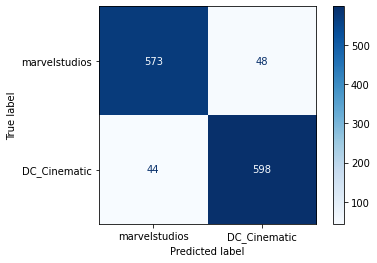

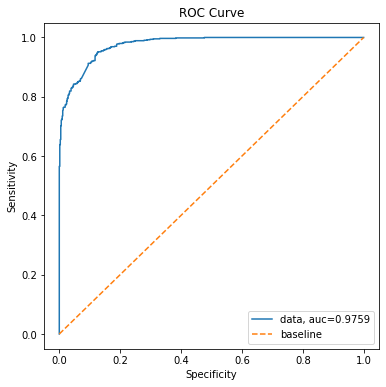

In [272]:
score_dict = analyse_model_performance(gs_tvec5, X1_train, y1_train, X1_test, y1_test)
scores.append(score_dict)
score_dict['model'] = "TF-IDF Vec + Multinomial NB (Stemmed Tokens)"

The train and test scores are above baseline however we find that the Multinomial Naive Bayes model with stemming does marginally worse than the model with lemmatization. This could be because the model is not able to identify correlated stemmed words as well as lemmatized words. 

In [273]:
df_scores = pd.DataFrame(scores)

In [274]:
df_scores.sort_values(by='test_accuracy_score', ascending=False)

,model,cross_val_score,train_auc_score,test_auc_score,train_accuracy_score,test_accuracy_score,sensitivity,specificity
5,TF-IDFVec + Multinomial Naive Bayes,0.981738,0.996901,0.982189,0.971826,0.929533,0.937695,0.921095
7,TF-IDF Vec + Multinomial NB (Stemmed Tokens),0.981645,0.996583,0.981538,0.968432,0.927158,0.931464,0.922705
4,CountVec + Multinomial Naive Bayes,0.980111,0.988572,0.981843,0.938221,0.925574,0.948598,0.901771
6,CountVec + Logistic Regression (Stemmed Tokens),0.981566,0.997990,0.981897,0.975560,0.919240,0.964174,0.872786
1,TF-IDFVec + Logistic Regression,0.982404,0.997272,0.983952,0.967074,0.918448,0.973520,0.861514
3,TF-IDF Vec + Random Forests,0.972682,0.999865,0.975488,0.995587,0.914489,0.973520,0.853462
2,CountVec + Random Forests,0.973005,0.999893,0.974334,0.995587,0.911322,0.948598,0.872786
0,CountVec + Logistic Regression,0.979381,0.994285,0.981774,0.908011,0.870942,0.993769,0.743961


### Which model to use for production?

We find that TF-IDFVec + Multinomial Naive Bayes (Lemmatized Tokens) model has the best accuracy score among all our models. It also has a very high AUC score. We find that the performance of this model is also very good compared to other models. Hence we decide to choose this model for production. 

In [275]:
df_scores.to_csv('../data/scores.csv')

# 4. Conclusion & Recommendations

Based on our findings we are able to accomplish the two tasks that we specified in our problem statement. 
1. Classifying the subreddits as Marvel or DC
Our best model can predict with 92.27% accuracy whether a given post comes from a Marvel or a DC subreddit, thus identifying a user as a marvel or DC fan. 

    For users of DC subreddits we recommend that DC Enterntainment should post targeted ads of specific DC movies, shows, comicbooks, merchandise for DC Fans. Please see point no.2 for additional recommendations about popular most characters. 

    For users of Marvel subreddits, we recommend that DC Enterntainment should focus on increasing their fan base by posting promotional ads for movie tickets and other promotional events.

2. Providing recommendations to our client for their advertising campaign by suggesting the the most popular words used in DC subreddit.<br>
From our analysis of most popular words in the subreddit we have the following reccomendations:

   DC Entertainment should focus on the following characters/titles when targetting ads to DC users:
    
        1. Batman
        2. Superman 
        3. Flash
        4. Zack Snyder's Justice League
        5. Shazam
        6. Suicide Squad
        7. Wonder Woman       
        8. Black Adam          
        9. Green Lantern      
        10. dark knight        
        11. harley quinn

   The following actors / creators also are trending on the DC subreddits and DC Entertainment can promote their sales by using references to them in their ads:
        1. Zack Snyder
        2. Henry Cavill
        3. Ben Affleck
        4. Michael Keaton

# 5. Future Steps

1. Our analysis only focuses on classifying subreddits into two classes DC and Marvel. As next steps we can also focus on a 3rd class called Others, which will help us to classify non-relevant subreddits as such. 
2. Collecting and modelling upon more data will help train the model more accurately and further reduce overfitting. With more processing power large amounts of data can be handled by our model. 
3. We can look beyond reddit at other platforms such as Twitter, Facebook etc. for similar analysis, this can help to train our model in more generic way, such that it can predict any sentence as being relevant for DC or Marvel. This will help in placing relevants ads in search engines such as Google.